In [123]:
from sklearn.datasets import make_blobs, load_digits, make_moons
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from timeit import timeit
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

## Cluster Analysis

### K-means

In [3]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [4]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [5]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

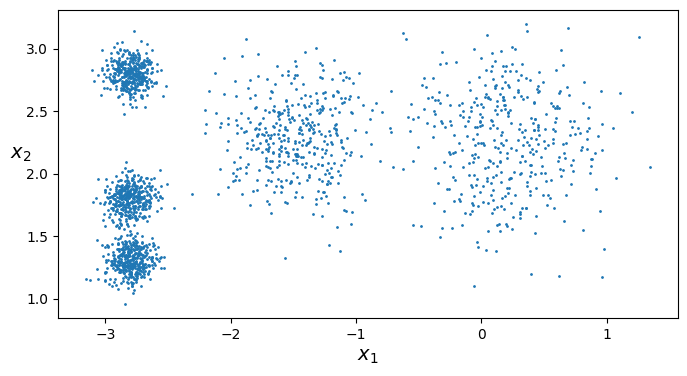

In [6]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [8]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

c:\Users\dawid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [10]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new) # clusters are labels from above example

array([1, 1, 2, 2])

In [11]:
kmeans.transform(X_new) # this shows how long distans is from particular point to different clusters centers 

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [12]:
kmeans.inertia_ # the lower it is the better clusters we have (avg square distance between every point and center of cluster)

211.59853725816834

In [16]:
kmeans.score(X) # same as above, but has to be negative in order to keep idea of that: bigger score - better results

-211.59853725816834

### K-means with mini groups

We can use it in order to apply big datasets, that too large to normal computation \
It's also much faster, but can have bigger interia

In [18]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

c:\Users\dawid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

In [19]:
kmeans.inertia_

211.59853725816834

In [23]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42, n_init='auto')
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init='auto', random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

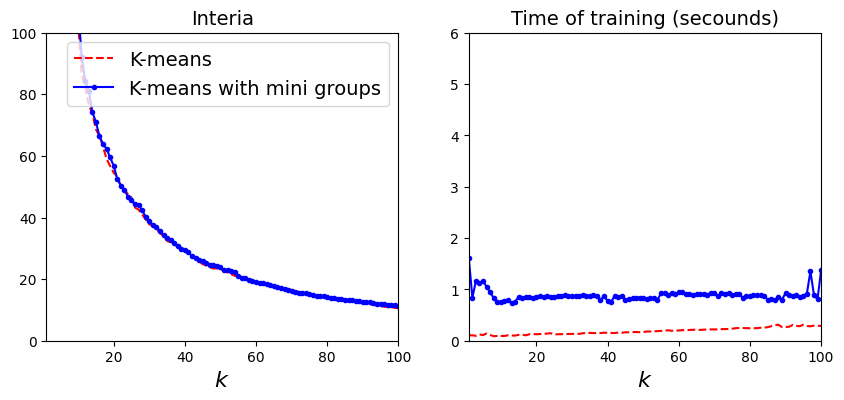

In [24]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="K-means with mini groups")
plt.xlabel("$k$", fontsize=16)
plt.title("Interia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="K-means with mini groups")
plt.xlabel("$k$", fontsize=16)
plt.title("Time of training (secounds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

### Searching for optimal value k

Elbow method

In [26]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

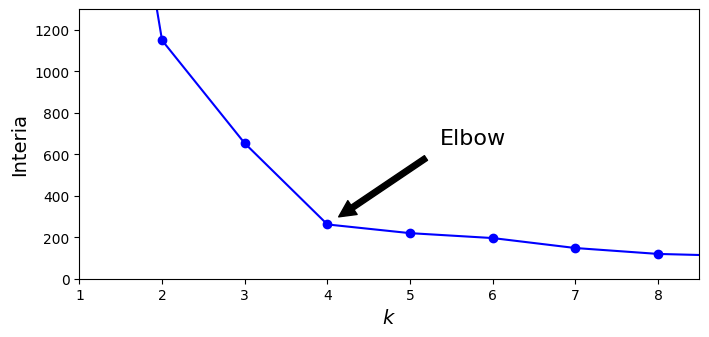

In [28]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Interia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

Silhouette Score - it's more precise, but also more complex (slower)

In [31]:
silhouette_score(X, kmeans.labels_) #the bigger it is, the better results we got

0.655517642572828

In [32]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

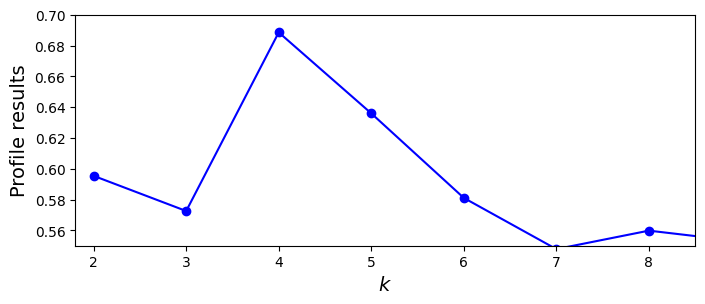

In [34]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Profile results", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

### Examples of using K-means algorithm

Image Segmentation

In [36]:
image = imread(r'data/ladybug.png')
image.shape

(533, 800, 3)

In [42]:
X = image.reshape(-1, 3)
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

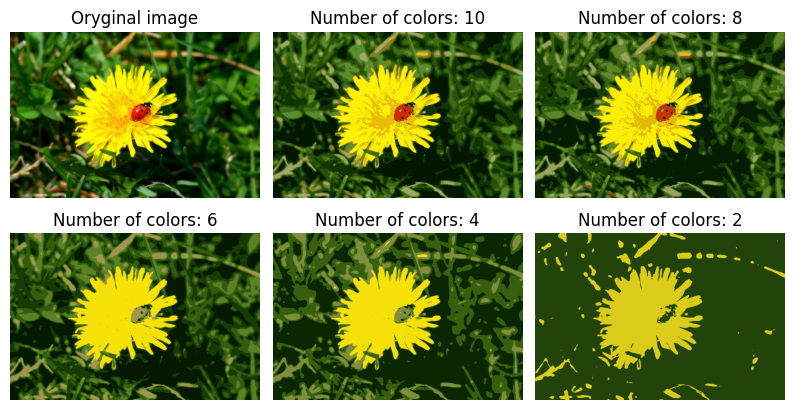

In [43]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Oryginal image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("Number of colors: {}".format(n_clusters))
    plt.axis('off')
plt.show()

Pre processing segmentation

In [45]:
X_digits, y_digits = load_digits(return_X_y=True)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [49]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [50]:
log_reg.score(X_test, y_test)

0.9688888888888889

In [52]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42, n_init='auto')),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans',
                 KMeans(n_clusters=50, n_init='auto', random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [53]:
pipeline.score(X_test, y_test)

0.9755555555555555

We dont care about best grouping in this particular example, since our goal is to reach best accurancy at model. \
Knowing that we dont have to find best k to grouping. We choose that with best impact to model.

In [57]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, n_init='auto',
                                               random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [58]:
grid_clf.best_params_

{'kmeans__n_clusters': 74}

In [59]:
grid_clf.score(X_test, y_test)

0.9755555555555555

Semi-Supervised learning (example with 50 samples)

In [60]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

In [62]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

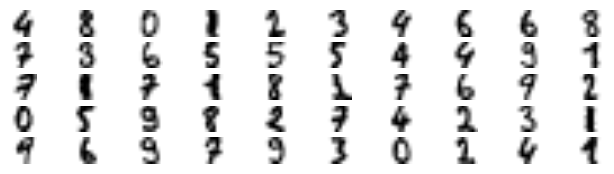

In [63]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

We mark it manualy

In [68]:
y_representative_digits = np.array([
    4, 8, 0, 2, 2, 3, 4, 6, 6, 8,
    7, 3, 6, 5, 5, 5, 4, 4, 9, 1,
    7, 1, 7, 1, 8, 1, 7, 6, 9, 2,
    0, 5, 9, 8, 2, 7, 4, 2, 3, 1,
    9, 6, 9, 7, 9, 3, 0, 2, 4, 1])

In [69]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9022222222222223

Propagation labels - we mark all other examples of dataset

In [70]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [72]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)


0.8822222222222222

We can choose how close of centroids we will mark examples

In [73]:
percentile_closest = 20 # 20% of closest examples near centroids

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [74]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [75]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9088888888888889

### DBSCAN 
We can find groups with different shapes (K-means have mostly circles)

In [77]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [78]:
dbscan = DBSCAN(eps=0.05, min_samples=5) # min_samples - minimum value when we can decide that there is a group around some certain point
dbscan.fit(X)

DBSCAN(eps=0.05)

In [80]:
dbscan.labels_[:10] #when value is -1 DBSCAN mark this as anomaly

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [81]:
len(dbscan.core_sample_indices_) #numbers of core examples

808

In [82]:
dbscan.core_sample_indices_[:10] # indexes of core examples

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [84]:
dbscan.components_[:10] #values of core examples (x,y)

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 1.26718285, -0.40793471],
       [ 0.87418608,  0.50781041],
       [ 0.3322007 , -0.19032202],
       [ 1.952812  ,  0.22552333]])

In [86]:
np.unique(dbscan.labels_) #unique groups

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [87]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [88]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

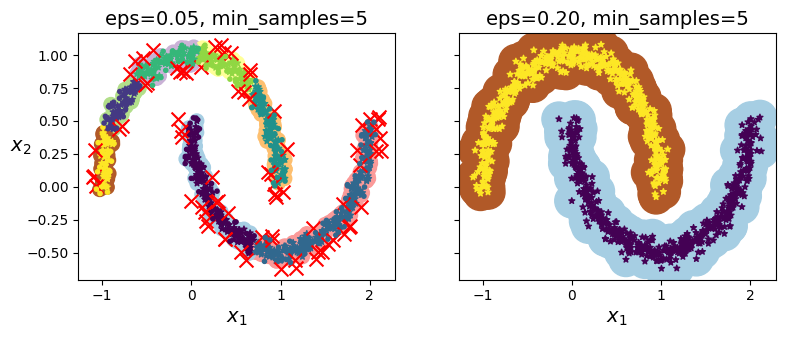

In [90]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()
dbscan = dbscan2

When we have some new data we want to predict:

In [92]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [93]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [94]:
knn.predict_proba(X_new) # with probability

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

## Gaussian mixtures model

In [96]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [100]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [102]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [103]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [104]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

In [106]:
print(gm.converged_) #if algorithm got convergence
print(gm.n_iter_) #how many iteration did it need

True
4


In [108]:
gm.predict(X) # set groups to samples

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [109]:
gm.predict_proba(X) # set groups to samples with probability

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

We can check new examples using this model

In [111]:
X_new, y_new = gm.sample(6)
print(X_new)
print(y_new)

[[-0.86944074 -0.32767626]
 [ 0.29836051  0.28297011]
 [-2.8014927  -0.09047309]
 [ 3.98203732  1.49951491]
 [ 3.81677148  0.53095244]
 [ 2.84104923 -0.73858639]]
[0 0 1 2 2 2]


In [113]:
gm.score_samples(X) # probability density function to every sample; the bigger value, the bigger density

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Finding anomalyies \
In this example we will choose about 4% of data

In [116]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]
len(anomalies)

50

Choosing "k" (numbers of groups we want to have)

In [118]:
print(gm.bic(X)) # method bic have less parameters
print(gm.aic(X)) # method aic is more detailed 

8189.747000497188
8102.52172038215


In [119]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)] # we train model with diffrent k 

In [120]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

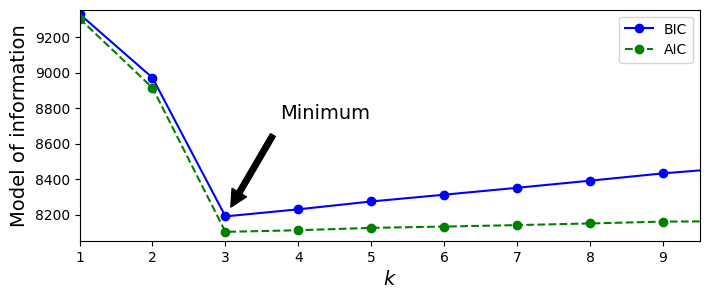

In [122]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Model of information", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

We can do it automatically

In [124]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [125]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

As well we can choose 3